
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



In [254]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from itertools import product


# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [255]:
df = pd.read_csv("datos/Truck_sales.csv")

Cargamos los datos.

In [256]:
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


Vamos a formatear nuestros datos de forma correcta y moverlos al índice.

In [257]:
df["Month-Year"] = pd.to_datetime(df["Month-Year"], format = r"%y-%b")

In [258]:
df = df.set_index("Month-Year")
df.index.name = "date"

Además, querremos comprobar que nuestros registros son completos, es decir, que no haya datos faltantes y una secuencia continua y con una frecuencia dada. En este caso tenemos datos mensuales, por lo que usaremos una frecuencia de MS : Month Start, y luego comprobaremos si había algún hueco en los datos contando los nulos que se nos hayan generado.

In [259]:
df = df.asfreq("MS")

In [260]:
df.isna().sum()

Number_Trucks_Sold    0
dtype: int64

Vemos que no hay nulos, lo cual indica que todos los datos para esa frecuencia estaban presentes.

Continuemos con una visualización inicial de nuestros valores.

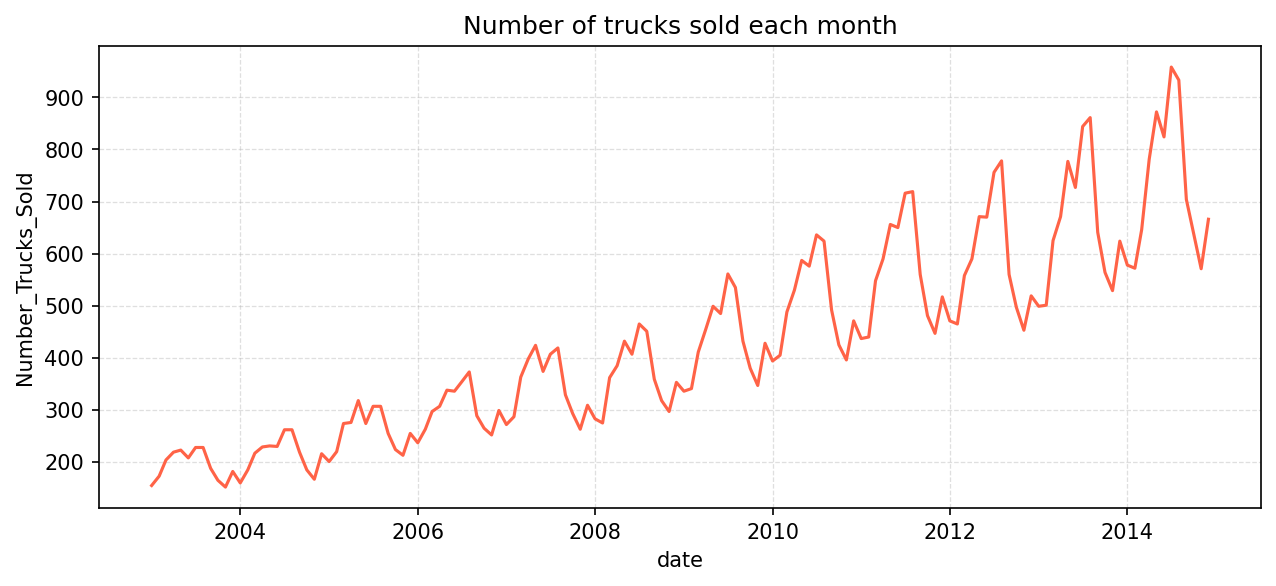

In [261]:
plt.figure(figsize = (10,4), dpi = 150)
plt.grid(lw = 0.6, ls = "--", alpha = 0.4)
sns.lineplot(data = df, x = "date", y = "Number_Trucks_Sold", color = "tomato")
plt.title("Number of trucks sold each month")
plt.show()

A primera vista, la serie con la que estamos tratando **no es estacionaria**, ya que apreciamos una tendencia y un aumento en su varianza. Vamos a realizar una descomposición estacional para comprobar estas observaciones.

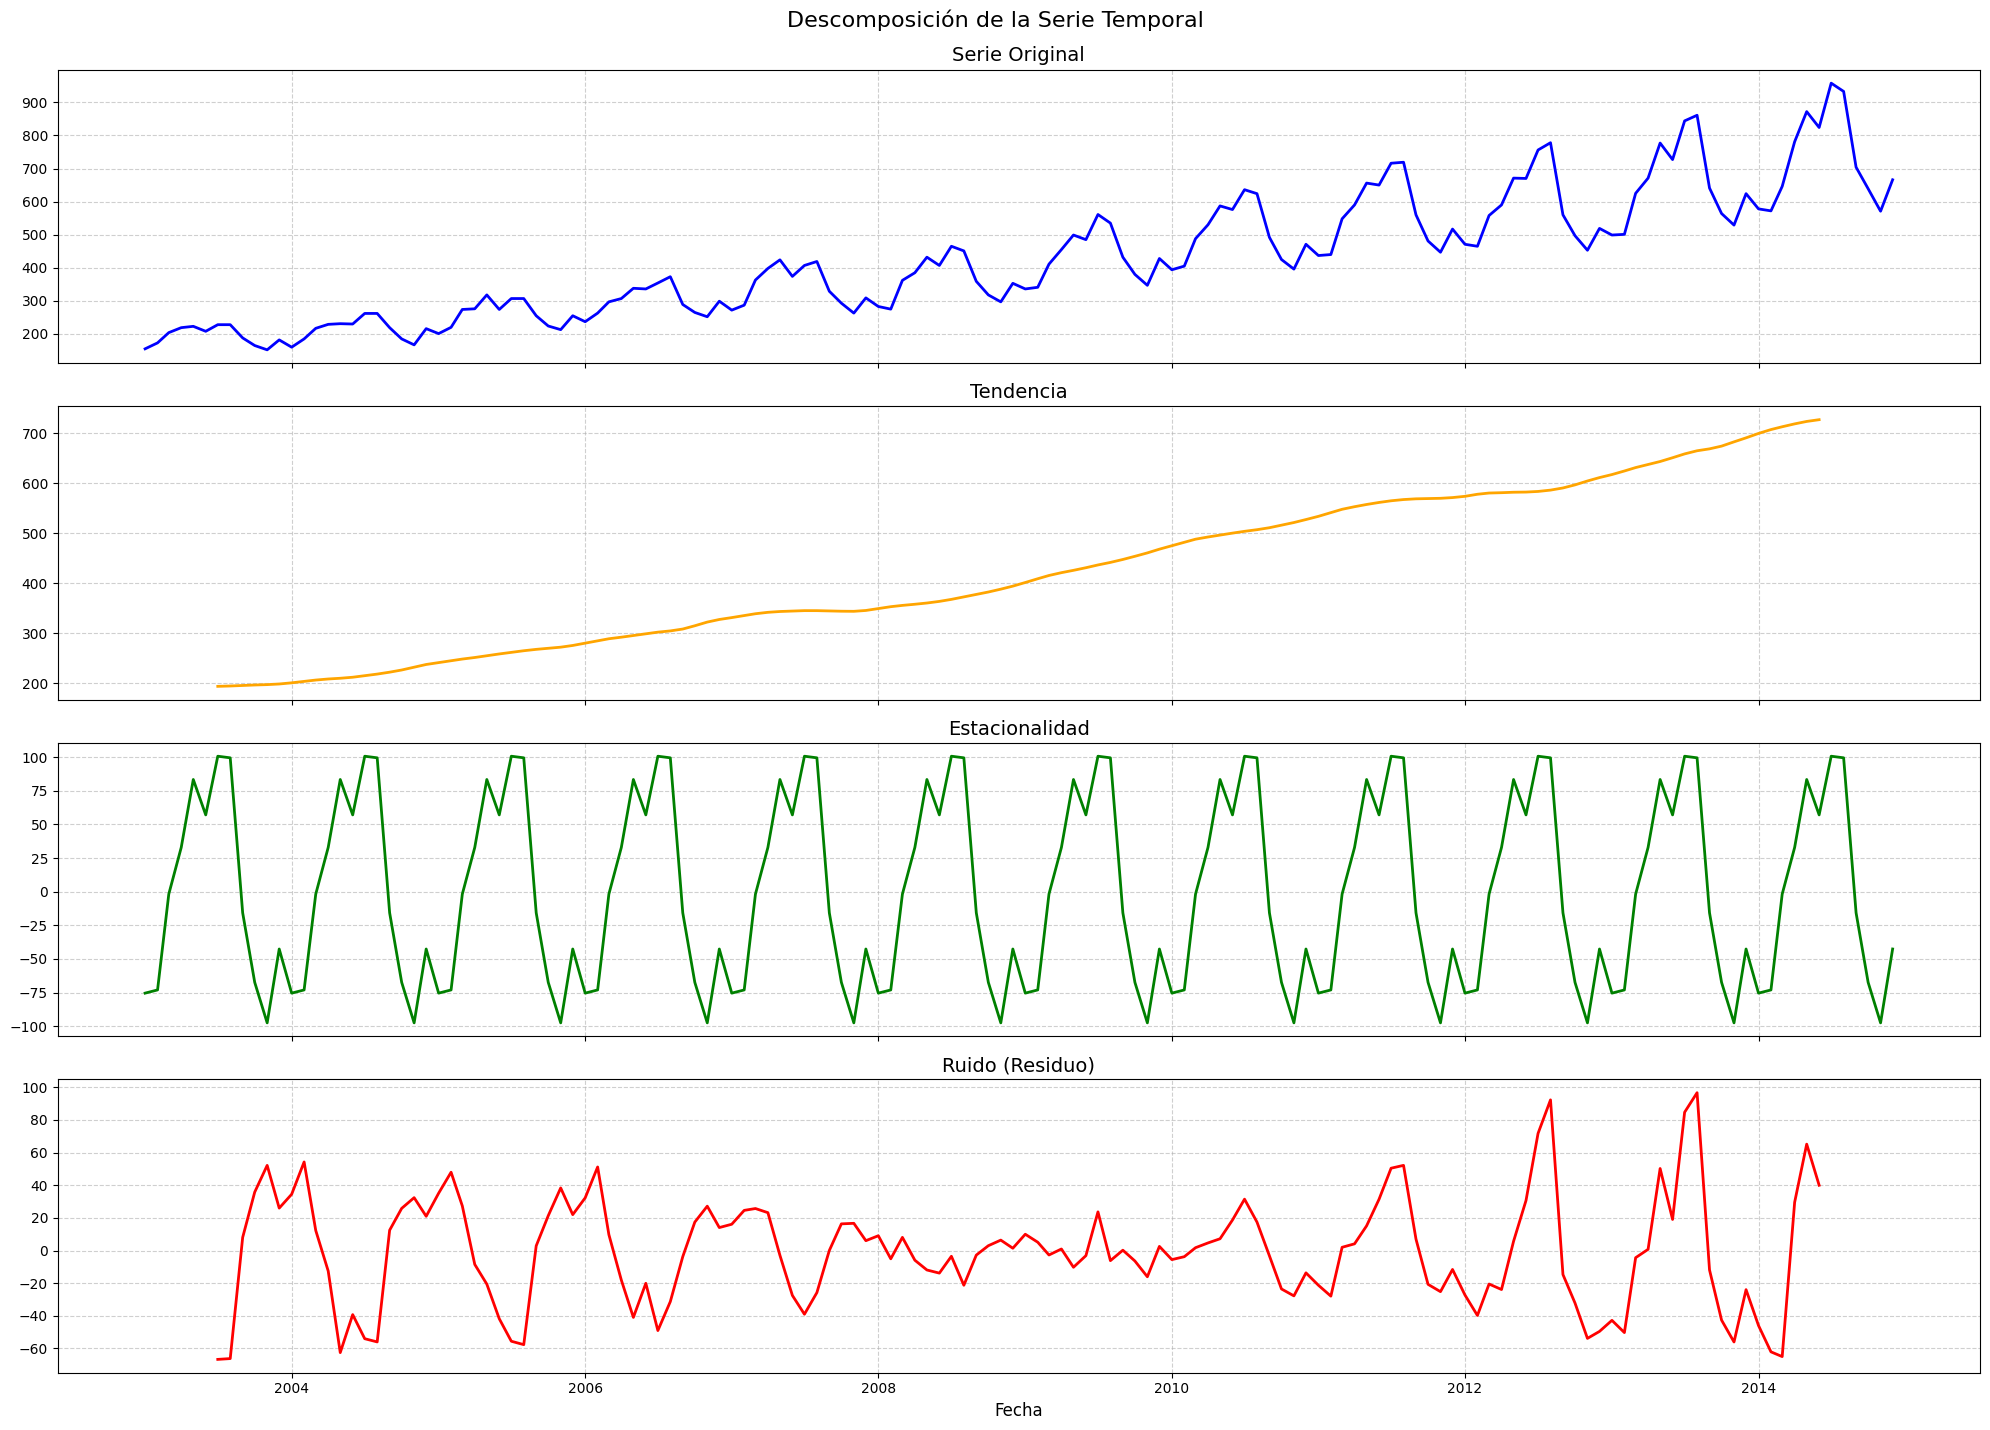

In [262]:
decomposition = seasonal_decompose(df, model='additive', period=12)

# Crear figura y subplots
fig, axes = plt.subplots(4, 1, figsize= (20, 15), sharex=True)

# Serie original
axes[0].plot(df, color="blue", linewidth=2)
axes[0].set_title("Serie Original", fontsize=14)
axes[0].grid(visible=True, linestyle="--", alpha=0.6)

# Tendencia
axes[1].plot(decomposition.trend, color="orange", linewidth=2)
axes[1].set_title("Tendencia", fontsize=14)
axes[1].grid(visible=True, linestyle="--", alpha=0.6)

# Estacionalidad
axes[2].plot(decomposition.seasonal, color="green", linewidth=2)
axes[2].set_title("Estacionalidad", fontsize=14)
axes[2].grid(visible=True, linestyle="--", alpha=0.6)

# Ruido
axes[3].plot(decomposition.resid, color="red", linewidth=2)
axes[3].set_title("Ruido (Residuo)", fontsize=14)
axes[3].grid(visible=True, linestyle="--", alpha=0.6)

# Ajustar diseño
plt.suptitle("Descomposición de la Serie Temporal", fontsize=16, y=0.95)
plt.xlabel("Fecha", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Observamos una clara tendencia como se mencionó anteriormente, y también comprobamos que nuestros datos tienen estacionalidad. Además, en la gráfica del residuo se ve perfectamente en qué date se vendían más o menos coches. Antes del 2008, las ventas eran menores (las series de estacionalidad y ruido tienen amplitudes opuestas), mientras que las ventas después de 2010 eran mayores (las series de estacionalidad y ruido están sincronizadas).

También podemos comprobar la no estacionareidad con un test ADFuller. Este método nos devolverá un p-value, con la hipótesis nula siendo que nuestros la serie no es estacionaria, por lo que si $p{\text -}val < 0.05$ la serie será estacionaria:

In [263]:
adfuller_result = adfuller(x = df)
pval = adfuller_result[1]
if pval<0.05:
    print(f"La hipótesis nula se rechaza, pval = {pval}, la serie es ESTACIONARIA")
elif pval > 0.05:
    print(f"La hipótesis nula se acepta, pval = {pval}, la serie es NO ESTACIONARIA")

La hipótesis nula se acepta, pval = 0.9953500083802601, la serie es NO ESTACIONARIA


Vemos que podemos decir con un 99% de confianza que nuestra hipótesis nula se cumple y, por tanto, nuestra serie no es estacionaria.

Para poder crear el modelo que nos permita predecir valores a partir de nuestra serie, será necesario transformar nuestra serie para que sea estacionaria. En nuestro método (SARIMAX), esta transformación ya se lleva a cabo, sin embargo, necesitamos las diferentes variables que están involucradas en esta transformación. Para averiguar los valores óptimos de éstas podemos aplicar dos métodos: **ACF y PACF**.

Antes de esto, habrá que diferenciar nuestros datos hasta que sean estacionarios. Además, el número de diferenciaciones necesarias será $d$ y $D$ (según el tipo de diferenciación):

In [264]:
print("1 Diferenciación pval:",adfuller(df.diff().dropna())[1])
print("2 Diferenciaciones pval:",adfuller(df.diff().diff().dropna())[1])

1 Diferenciación pval: 0.10573354923819694
2 Diferenciaciones pval: 5.1580380637984164e-14


Vemos que en este caso las diferenciaciones normales necesarias es 2, por lo que $d=2$.

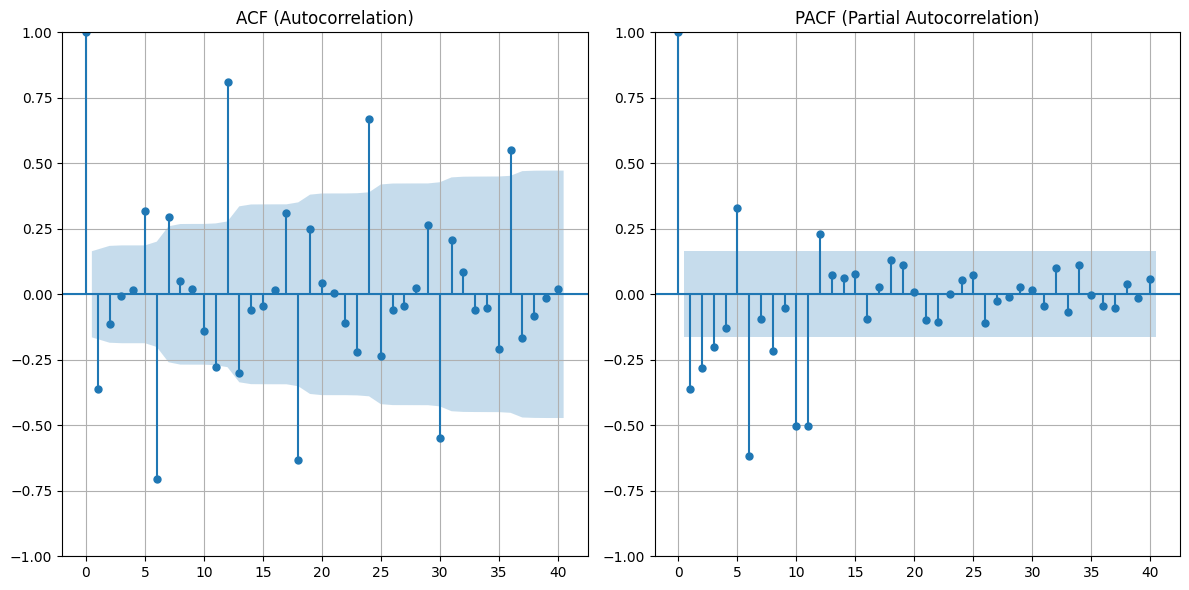

In [265]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(x=df.diff().diff().dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF (Autocorrelation)")
axes[0].grid()
plot_pacf(x=df.diff().diff().dropna(), lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (Partial Autocorrelation)")
axes[1].grid()
plt.tight_layout()
plt.show()

Viendo la gráfica podemos deducir que $q = 1$ y $p = 3$ (los lags entran en la zona no significativa a partir de estos valores en el ACF y PACF).

Ahora para D, Q y P:

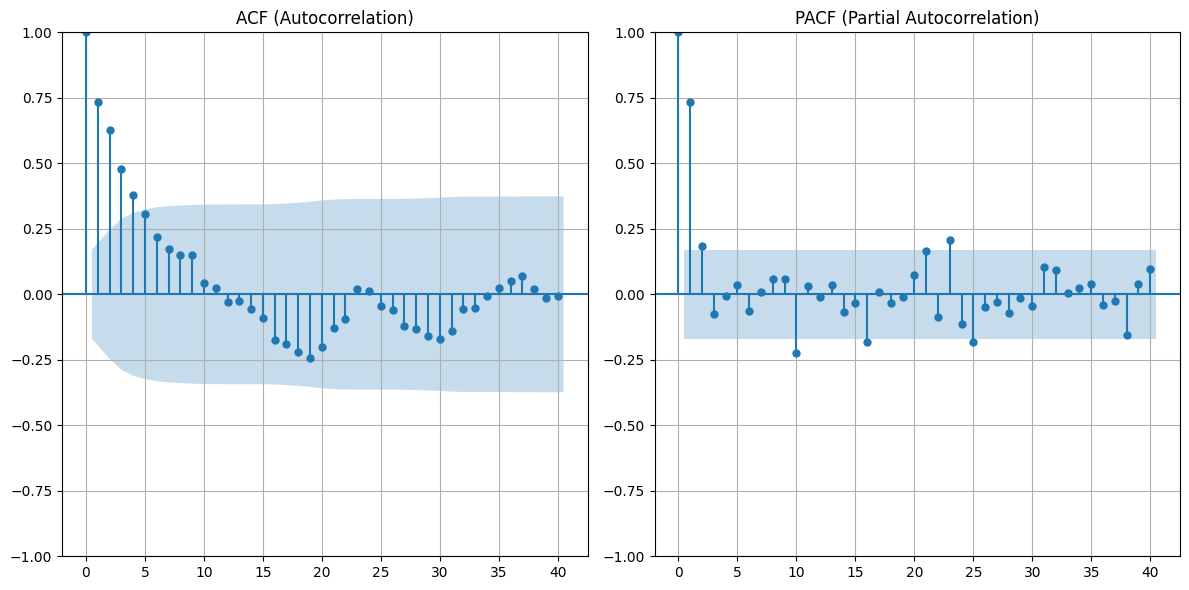

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(x=df.diff(periods =12).dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF (Autocorrelation)")
axes[0].grid()
plot_pacf(x=df.diff(periods=12).dropna(), lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (Partial Autocorrelation)")
axes[1].grid()
plt.tight_layout() 
plt.show()

Tras una diferenciación estacional, vemos visualmente que obtenemos una estacionareidad estacional, por lo que $D=1$. Además mirando ACF y PACF nos indica que $Q = 4$ y $P = 1$. Cabe recalcar que todos estos valores que obtenemos son un punto de partida, las métricas son las que nos dirán qué valores son los más óptimos para el caso de estudio.

## Entrenamiento del Modelo

In [267]:
train_size = int(0.7 * len(df))
y_train, y_test = df[:train_size], df[train_size:]

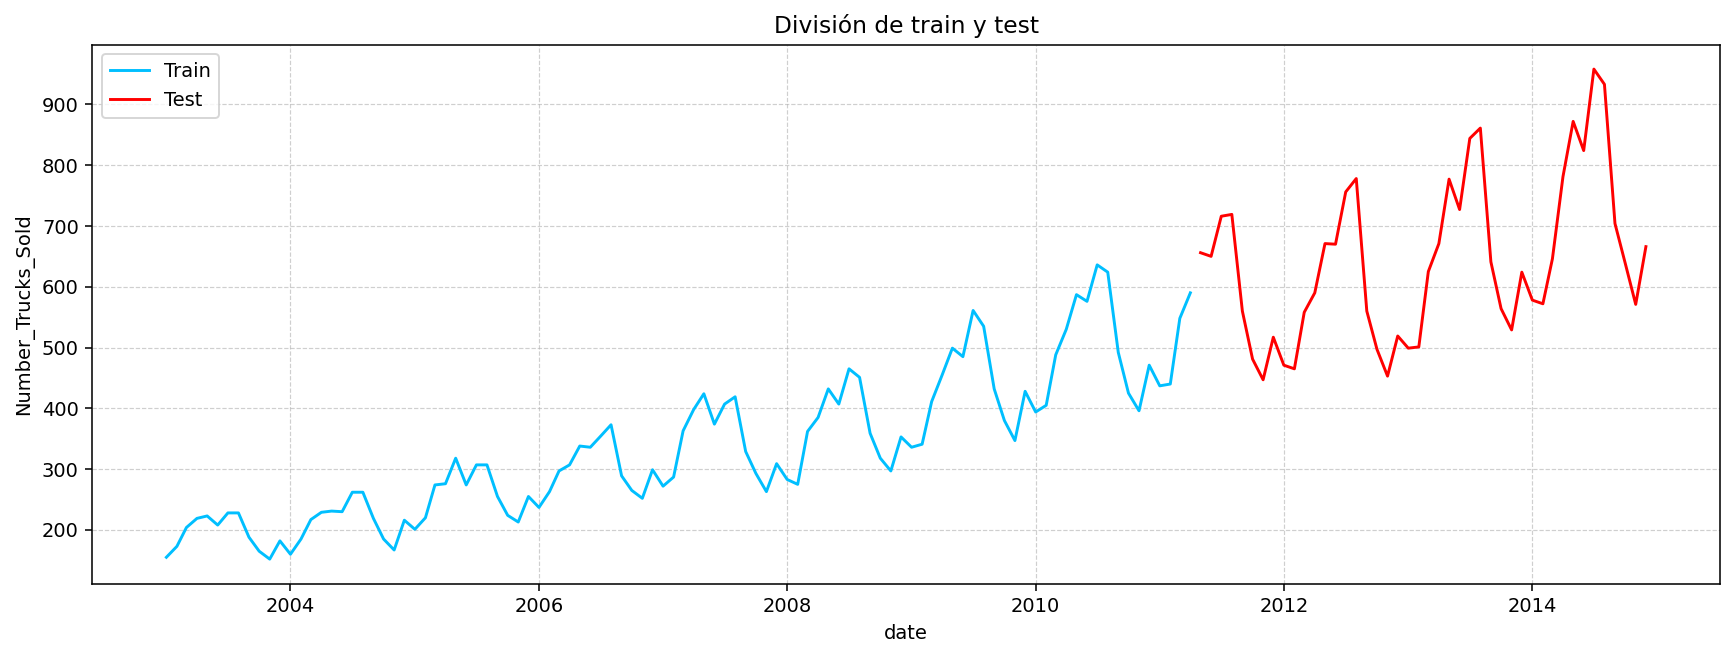

In [268]:
plt.figure(figsize=(15,5), dpi = 140)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.lineplot(data=y_train, x = y_train.index, y = "Number_Trucks_Sold", color="deepskyblue", label="Train")
sns.lineplot(data=y_test, x = y_test.index, y = "Number_Trucks_Sold", color="red", label="Test")
plt.legend()
plt.title("División de train y test")
plt.show()

Hemos dividido la muestra en datos para el train y datos para el test. Ahora construyamos el modelo con todo lo recopilado hasta ahora:

In [269]:
p_range = range(1, 4)
q_range = range(1, 2)
d = 2

P_range = range(2)
Q_range = range(5)
D_range = [1]
S_range = [6,12]
parametros = [
            (p, q, (P, D, Q, S))
            for p, q, (P, D, Q, S) in product(
                p_range, q_range, product(P_range, D_range, Q_range, S_range)
            )
        ]


In [270]:
results = []
for p, q, seasonal_order in tqdm(parametros):
    try:
        # Crear y entrenar el modelo SARIMAX
        modelo_sarima = SARIMAX(
            y_train,
            order=(p, d, q),
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)


        start_index = len(y_train)
        end_index = len(df) - 1
        pred_test = modelo_sarima.predict(start=start_index, end=end_index)
        pred_test = pd.Series(pred_test, index=y_test.index)  # Convertir a Serie de pandas

        # Calcular RMSE para el conjunto de prueba
        error = np.sqrt(mean_squared_error(y_test, pred_test))
        results.append({"p": p, "q": q, "seasonal_order": seasonal_order, "RMSE": error})


    except Exception as e:
        # Manejar errores durante el ajuste
        results.append({"p": p, "q": q, "seasonal_order": seasonal_order, "RMSE": None})
        print(e)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


In [271]:
results_df.sort_values("RMSE").head()

,p,q,seasonal_order,RMSE
9,1,1,"(0, 1, 4, 12)",29.769676
29,2,1,"(0, 1, 4, 12)",29.929492
49,3,1,"(0, 1, 4, 12)",30.887388
16,1,1,"(1, 1, 3, 6)",31.724469
36,2,1,"(1, 1, 3, 6)",31.820647


Vemos que los mejores valores los obtenemos con $p = 1$, $q = 1$,  $(P = 0, D = 1, Q = 4, S = 12)$, algo diferentes que lo que predijimos. Las componentes estacionales son exactamente las que dedujimos, pero la $p$ es ligeramente diferente.

In [272]:
modelo_sarima = SARIMAX(
            y_train,
            order=(1, 2, 1),
            seasonal_order=(0,1,4,12),
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)

test_forecast = modelo_sarima.get_forecast(steps=len(y_test))


In [273]:
pred_test = test_forecast.predicted_mean
conf_int = test_forecast.conf_int()

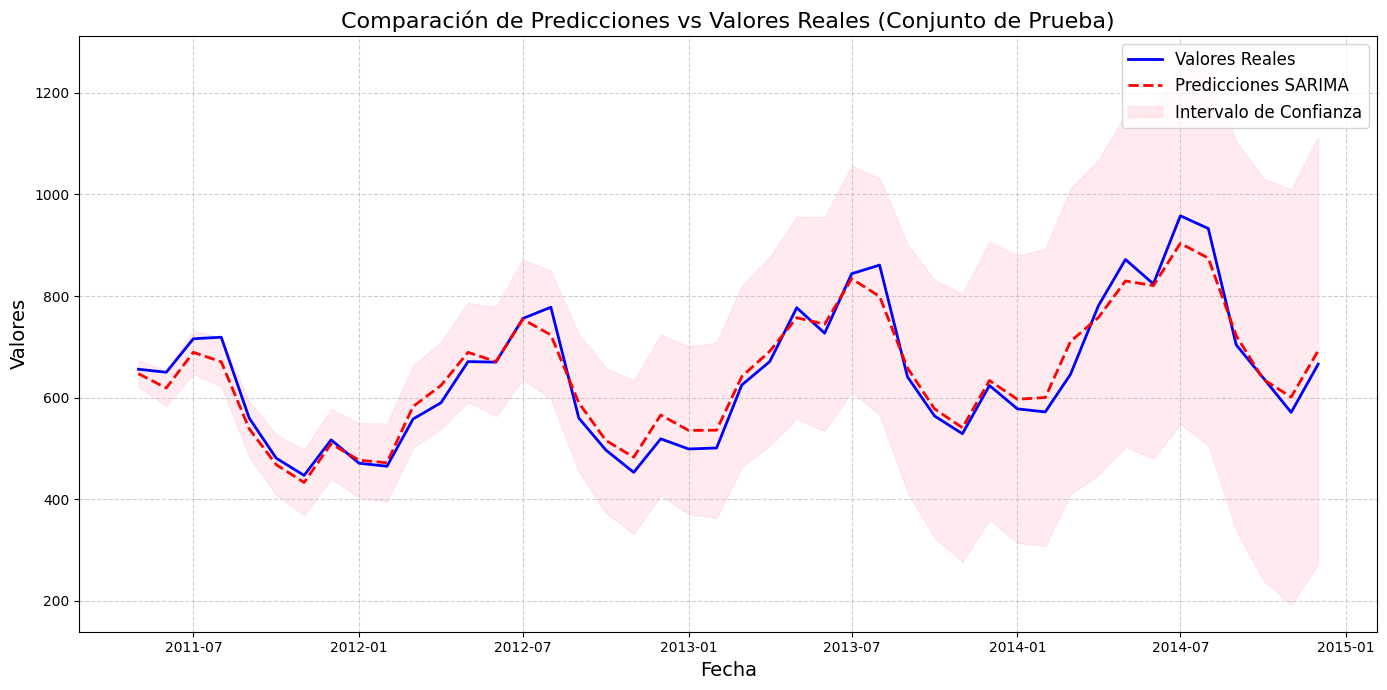

In [274]:
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(x=y_test.index, y=y_test["Number_Trucks_Sold"], label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(x=y_test.index, y=pred_test, label="Predicciones SARIMA", color="red", linestyle="--", linewidth=2)

# Graficar intervalo de confianza
plt.fill_between(
    y_test.index,
    conf_int.iloc[:, 0],  # Límite inferior
    conf_int.iloc[:, 1],  # Límite superior
    color="pink",
    alpha=0.3,
    label="Intervalo de Confianza",
)

# Personalización
plt.title("Comparación de Predicciones vs Valores Reales (Conjunto de Prueba)", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Valores", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Vemos que las predicciones en sí son bastante cercanas a los valores reales. Sin embargo tenemos intervalos de confianza que van aumentando bastante comforme va avanzando en el tiempo. Esto es normal, ya que el error se propaga con el tiempo, y para predicciones cercanas es capaz de hacerlas con un menor intervalo, mientras que cuanto más en el futuro se haga la predicción, más imprecisa puede llegar a ser.

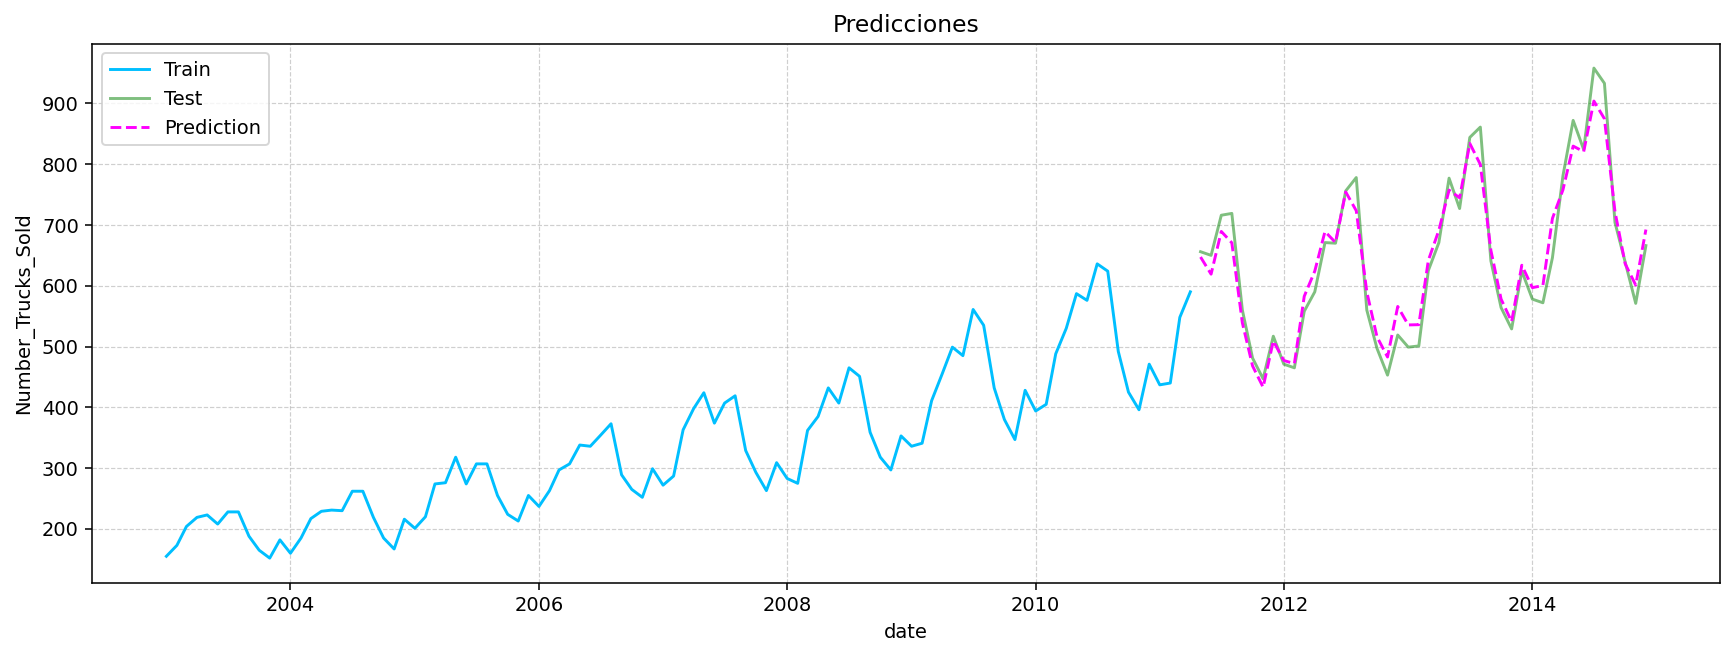

In [281]:
plt.figure(figsize=(15,5), dpi = 140)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.lineplot(data=y_train, x = y_train.index, y = "Number_Trucks_Sold", color="deepskyblue", label="Train")
sns.lineplot(data=y_test, x = y_test.index, y = "Number_Trucks_Sold", color="green", alpha = 0.5, label="Test")
sns.lineplot(x=y_test.index, y=pred_test, color="magenta", ls = "--", label="Prediction")

plt.legend()
plt.title("Predicciones")
plt.show()

In [287]:
modelo_sarima_complete = SARIMAX(
            df,
            order=(1, 2, 1),
            seasonal_order=(0,1,4,12),
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)

forecast_next12 = modelo_sarima_complete.get_forecast(steps=12)

In [288]:
pred_next12 = forecast_next12.predicted_mean
conf_int_next12 = forecast_next12.conf_int()

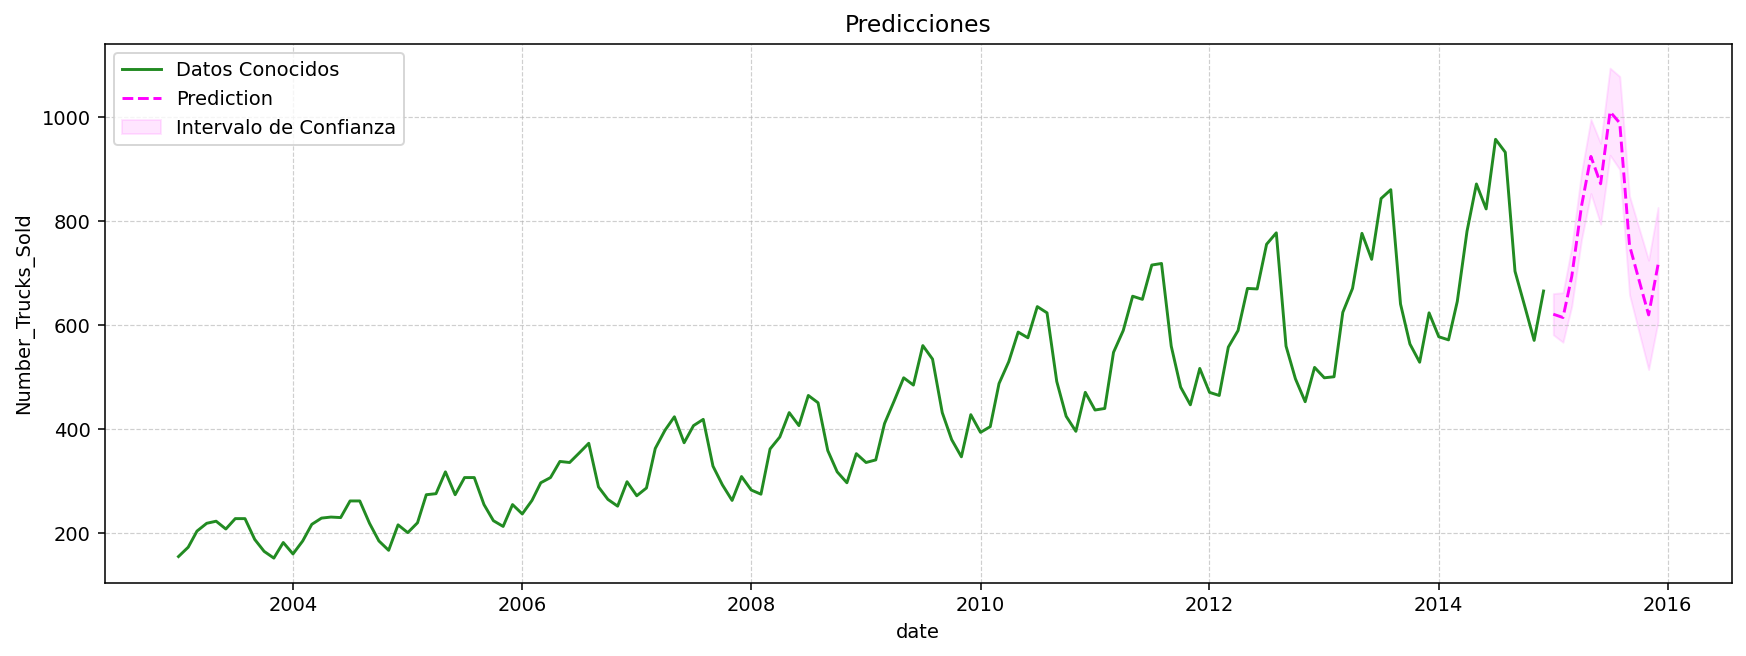

In [289]:
plt.figure(figsize=(15,5), dpi = 140)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.lineplot(data=df, x = df.index, y = "Number_Trucks_Sold", color="forestgreen", label="Datos Conocidos")
sns.lineplot(x=pred_next12.index, y=pred_next12, color="magenta", ls = "--",  label="Prediction")

plt.fill_between(
    pred_next12.index,
    conf_int_next12.iloc[:, 0],  # Límite inferior
    conf_int_next12.iloc[:, 1],  # Límite superior
    color="magenta",
    alpha=0.1,
    label="Intervalo de Confianza",
)

plt.legend()
plt.title("Predicciones")
plt.show()

A primera vista parecen unas predicciones bastante razonables para los siguientes 12 meses. Además, al no ser predicciones muy lejanas, obtenemos un intervalo de confianza bastante contenido.